In [1]:
import ee
import numpy as np
import pandas as pd

from earthshot import mon_stats
from earthshot import water_viz as vis
from earthshot import normalize as norm
from earthshot import water_common as common
from statistics import mean

import geemap.eefolium as geemap
import folium
from folium import plugins

import matplotlib.pyplot as plt
%matplotlib inline

Loading BokehJS ...

In [2]:
ee.Initialize()

In [23]:
#Join beaver dam tables

def set_present(feature):
    return feature.set('Beaver Dam', 1)

def set_absent(feature):
    return feature.set('Beaver Dam', 0)

CA_Dam_Data_Present = ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/06_CaliforniaDams_Boxes_yes_BeaverDam')
CA_Dam_Data_Absent = ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/06_CaliforniaDams_Boxes_no_BeaverDam')
CO_Dam_Data_Present = ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/05_ColoradoDams_Boxes_yes_BeaverDam').merge(ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/05_ColoradoDams_Boxes_allIntersect'))
CO_Dam_Data_Absent = ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/05_ColoradoDams_Boxes_no_BeaverDam')
ID_Dam_Data_Present = ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/04_IdahoDams_Boxes_yes_BeaverDam').merge(ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/04_IdahoDams_Boxes_allIntersect'))
ID_Dam_Data_Absent = ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/04_IdahoDams_Boxes_no_BeaverDam')
WY_Dam_Data_Present = (ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/01_WyomingDams_Boxes_yes_BeaverDam')
                       .merge(ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/01_WyomingDams_Boxes_allIntersect'))
                       .merge(ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/02_WyomingDams_Boxes_yes_BeaverDam'))
                       .merge(ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/02_WyomingDams_Boxes_allIntersect')))
WY_Dam_Data_Absent = (ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/01_WyomingDams_Boxes_no_BeaverDam')
                      .merge(ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/02_WyomingDams_Boxes_yes_BeaverDam')))
OR_Dam_Data_Present = (ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/03_OregonDams_Boxes_yes_BeaverDam')
                       .merge(ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/03_OregonDams_Boxes_allIntersect')))
OR_Dam_Data_Absent = ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/03_OregonDams_Boxes_no_BeaverDam')

dam_data_present = (CA_Dam_Data_Present.merge(CO_Dam_Data_Present).merge(ID_Dam_Data_Present).merge(WY_Dam_Data_Present).merge(OR_Dam_Data_Present)).map(set_present)

dam_data_absent = CA_Dam_Data_Absent.merge(CO_Dam_Data_Absent).merge(ID_Dam_Data_Absent).merge(WY_Dam_Data_Absent).merge(OR_Dam_Data_Absent).map(set_absent)

dam_data = dam_data_present.merge(dam_data_absent)



#def set_geometry(feature):
 #   geometry = ee.Geometry(feature.get('.geo'))
 #   feature_new = feature.setGeometry(geometry.centroid())
  #  return feature_new
    
#dam_data_merged = dam_data.map(set_geometry)

print(dam_data.first().getInfo())

{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-118.19555445223814, 35.95694683227378], [-118.1943549676864, 35.9569468129219], [-118.1943549676864, 35.958146276883795], [-118.19555445223814, 35.958146287564674], [-118.19555445223814, 35.95694683227378]]]}, 'id': '1_1_1_1_1_00000000000000000010', 'properties': {'Beaver Dam': 1, 'angle': 180, 'area': 1e-06, 'cat': 598, 'distance': 0, 'fid': 262, 'height': 0.0012, 'network': 12, 'perimeter': 0.0048, 'stream_typ': 'start', 'type_code': 0, 'width': 0.0012}}


In [6]:
eco_regions = ee.FeatureCollection('users/amgadellaboudy/Eco_Regions')

innerJoin = ee.Join.inner()
def cleanJoin(feature):
    new_feature = ee.Feature(feature.get('primary')).copyProperties(feature.get('secondary'))
    return new_feature

spatialFilter = ee.Filter.intersects(leftField = '.geo', rightField = '.geo', maxError = 10)
eco_dam_data = innerJoin.apply(dam_data, eco_regions, spatialFilter)
eco_dam_data_clean = eco_dam_data.map(cleanJoin)
dam_feat = eco_dam_data_clean.remap(lookupIn = ['16', '21', '5'], lookupOut = [0, 1, 2], columnName = 'US_L3CODE')


In [113]:
bbox_conus = ee.Geometry.BBox(-125, 30, -103, 49)
bbox_global = ee.Geometry.BBox(-180, -90, 180, 90)

#Import variables in (Slope, Porosity, Runoff, Soil Types, Annual Precipitation, water accumulation)
slope_img = ee.Image('users/jamesmcc/merit_slope/merit_terrain_slope')
#slope_global = ee.Image('users/jamesmcc/merit_slope/merit_terrain_slope')
#Scale = 90 m

temp_img = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY").filterDate('2020-01-01', '2020-12-31').select('temperature_2m').mean().clip(bbox_conus)
#temp_global = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY").filterDate('2020-01-01', '2020-12-31').select('temperature_2m').mean()

runoff_img = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY").filterDate('2020-01-01', '2020-12-31').select('surface_runoff').mean().clip(bbox_conus)
#runoff_clim_m = mon_stats.bands_avgs(['surface_runoff'], runoff_clim)
#runoff_img = ee.ImageCollection(runoff_clim_m['avgs'].get('surface_runoff')).sum().multiply(720)
#runoff_max = runoff_clim.max().multiply(720)

precip_img = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY").filterDate('2020-01-01', '2020-12-31').select('total_precipitation').mean().clip(bbox_conus)

#precip_clim = ee.Image("OpenLandMap/CLM/CLM_PRECIPITATION_SM2RAIN_M/v01")
#precip_img = precip_clim.reduce('sum')
#https://developers.google.com/earth-engine/datasets/catalog/OpenLandMap_CLM_CLM_PRECIPITATION_SM2RAIN_M_v01#bands
#Scale = 1 km

soil_types = ee.Image("OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02")

top_soils = soil_types.expression('soil_0 + soil_10 + soil_30',
                             {'soil_0': soil_types.select('b0'),
                             'soil_10': soil_types.select('b10'),
                             'soil_30': soil_types.select('b30')}).clip(bbox_conus)

water_img = ee.Image("MERIT/Hydro/v1_0_1").select('viswth').clip(bbox_conus)
#print(norm.img_range(water_img))
#https://developers.google.com/earth-engine/datasets/catalog/MERIT_Hydro_v1_0_1#bands
#Scale = 90 m

land_use = ee.Image("COPERNICUS/Landcover/100m/Proba-V-C3/Global/2019").select('discrete_classification')
#https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_Landcover_100m_Proba-V-C3_Global#image-properties

land_mask = land_use.neq(80)


In [9]:
#function to calculate NDVI

def addNDVI(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

In [10]:
#function to mask clouds
def maskS2clouds(image):
    qa = image.select('QA60')

    ## Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    ## Both flags should be set to zero, indicating clear conditions.
    mask = (qa.bitwiseAnd(cloudBitMask).eq(0)).And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    return image.updateMask(mask).divide(10000)

In [114]:
NDVI = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterDate('2020-01-01', '2020-12-31')
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20))
        .map(maskS2clouds)
        .map(addNDVI)
        .select('NDVI')
        .mean()
        .clip(bbox_conus)
        .updateMask(land_mask))

In [115]:
training_img = slope_img.addBands(runoff_img).addBands(precip_img).addBands(top_soils).addBands(NDVI).addBands(temp_img)
print(training_img.bandNames().getInfo())

['slope', 'surface_runoff', 'total_precipitation', 'b0', 'NDVI', 'temperature_2m']


In [116]:
target = 'NDVI'
bands = ['slope', 'surface_runoff', 'total_precipitation', 'b0', 'temperature_2m', 'Beaver Dam']
not_null = ['NDVI', 'slope', 'surface_runoff', 'total_precipitation', 'b0','temperature_2m', 'Beaver Dam']

split = 0.5
random = dam_data.randomColumn()
dam_split = random.filter(ee.Filter.gte('random', split))

training = training_img.reduceRegions(collection = dam_split, reducer = ee.Reducer.mean(), scale = 25, tileScale = 16).filter(ee.Filter.notNull(not_null))

In [117]:
#Test/ validation split, fit classifier for training data

#random = training.randomColumn(columnName = 'randomized', seed = 101)

#training_split = random.filter(ee.Filter.lt('randomized', split))
#validation_split = random.filter(ee.Filter.gte('randomized', split))

trained_classifier = ee.Classifier.smileGradientTreeBoost(750).setOutputMode('REGRESSION').train(features= training, classProperty= target, inputProperties = bands)


In [118]:
#Create predicted MAR intervention image and validation data

validated = training.classify(trained_classifier)

In [43]:
trained_image = training_img.clip(bbox_conus).classify(trained_classifier)

In [119]:
#Training accuracy
from sklearn import metrics

selectors = ee.List(['NDVI', 'classification'])
list_1 = ee.List(validated.reduceColumns(reducer = ee.Reducer.toList().repeat(selectors.size()), selectors = selectors).get('list'))

y_test = ee.List(list_1.get(0)).getInfo()
predictions = ee.List(list_1.get(1)).getInfo()

RMSE = np.sqrt(metrics.mean_squared_error(y_test, predictions))
print('RMSE:', RMSE)

RMSE: 0.0535707863327849


In [120]:
average_data = np.mean(y_test)
percentage = (RMSE/average_data)*100
print(percentage)

17.26648722544128


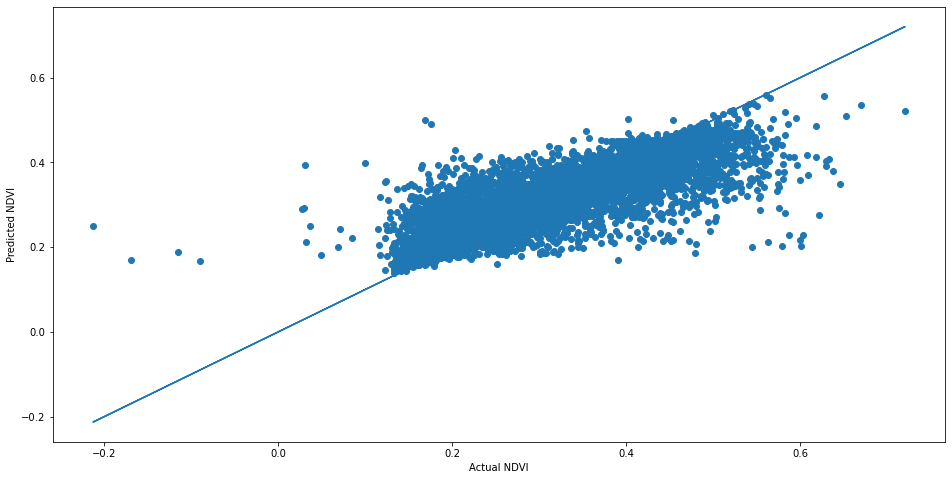

In [121]:


fig, ax = plt.subplots()

scatter = ax.scatter(y_test, predictions)
plot = ax.plot(y_test, y_test)


plt.xlabel('Actual NDVI')
plt.ylabel('Predicted NDVI')
fig.set_figwidth(16)
fig.set_figheight(8)

plt.show()


In [122]:
viz_params = {'min': 0.25, 'max': 0.50, 'palette': ['Red', 'Yellow', 'Green']}
viz_params_change = {'min': -0.50, 'max': 0.50, 'palette': ['Red', 'Yellow', 'Green']}
viz_params_runoff = {'min': 0, 'max': 0.0001, 'palette': ['Red', 'Yellow', 'Green']}
viz_params_precip = {'min': 0, 'max': 0.005, 'palette': ['Red', 'Yellow', 'Green']}
viz_params_big = {'min': 0, 'max': 30, 'palette': ['Red', 'Yellow', 'Green']}
viz_params_temp = {'min': 270, 'max': 300, 'palette': ['Blue', 'Yellow', 'Red']}

mask = water_img.gte(0.5)
subtraction = trained_image.subtract(NDVI)
NDVI_change = subtraction.updateMask(mask)

dataset = (ee.ImageCollection('USDA/NAIP/DOQQ')
                  .filter(ee.Filter.date('2018-01-01', '2018-12-31')))
trueColor = dataset.select(['R', 'G', 'B'])
trueColorVis = {'min': 0.0, 'max': 255.0}


the_map = geemap.Map()
the_map.addLayer(NDVI, viz_params, name = 'NDVI')
the_map.addLayer(trueColor, trueColorVis, 'True Color');
the_map.addLayer(runoff_img, viz_params_runoff, name = 'runoff_img')
the_map.addLayer(precip_img, viz_params_precip, name = 'precip_img')
the_map.addLayer(top_soils, viz_params_big, name = 'top_soils')
the_map.addLayer(water_img, viz_params, name = 'water_img')
the_map.addLayer(temp_img, viz_params_temp, name = 'temp_img')
#the_map.addLayer(NDVI_change, viz_params_change, name = 'NDVI Change')

vis.folium_display(the_map)